# Data ETL

## Initialize Packages

In [ ]:
import pandas as pd
import numpy as np
# import polars as pl
import gdown
import os
import rich
# import pyarrow
import fastparquet

In [6]:
# UNCOMMENT CODE IN THIS CHUNK FOR THE FIRST TIME USING THIS REPO - Onetime data downloading from Google Drive
# https://drive.google.com/file/d/1Wvf4WmgOVFLu3snFkIUYI6Y5unM9b5o1/view?usp=drive_link
# https://drive.google.com/file/d/17j2pkUwyUdOWg3-2xKQReL2JVHtSbGSN/view?usp=drive_link
model_file_id = "1Wvf4WmgOVFLu3snFkIUYI6Y5unM9b5o1"
gdown.download(
    f"https://drive.google.com/uc?id={model_file_id}",
    'synthetic_auto_policies_model_data_10042025.csv', 
    quiet=False)
inference_file_id = "17j2pkUwyUdOWg3-2xKQReL2JVHtSbGSN"
gdown.download(
    f"https://drive.google.com/uc?id={inference_file_id}",
    'synthetic_auto_policies_inference_data_10042025.csv', 
    quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Wvf4WmgOVFLu3snFkIUYI6Y5unM9b5o1
To: /Users/varunvaidya/Hawkeye-Datathon-2025/backend/synthetic_auto_policies_model_data_10042025.csv
100%|██████████| 1.92M/1.92M [00:00<00:00, 13.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=17j2pkUwyUdOWg3-2xKQReL2JVHtSbGSN
To: /Users/varunvaidya/Hawkeye-Datathon-2025/backend/synthetic_auto_policies_inference_data_10042025.csv
100%|██████████| 1.51M/1.51M [00:00<00:00, 12.5MB/s]


'synthetic_auto_policies_inference_data_10042025.csv'

## Extract Data

In [3]:
model_data = pd.read_csv('../backend/model_data.csv')
print(model_data.shape)
model_data.head(5)

(15000, 25)


,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [4]:
inference_data = pd.read_csv('../backend/inference_data.csv')
print( inference_data.shape )
inference_data.head(5)

(15000, 19)


,id,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind
0,8295,6.36,0.777085,SUV,3,M,A,2,hybrid,128,81,silver,S,1,weekend,6am - 12pm,12,644.721808,0
1,17625,2.56,0.528369,STNWG,1,F,A,1,dissel,178,94,white,S,1,weekday,12pm - 6pm,12,634.306196,0
2,3802,6.18,0.384591,HDTOP,4,F,D,3,petrol,270,77,yellow,M,1,weekday,6pm - 12am,12,649.245139,0
3,12865,6.49,0.116378,SUV,3,M,D,4,petrol,120,59,gray,S,1,weekday,6am - 12pm,12,647.594655,0
4,6495,6.46,0.688417,SEDAN,2,F,C,4,petrol,94,81,green,S,1,weekday,6am - 12pm,12,657.550500,0


## Clean Data

In [5]:
import numpy as np
import pandas as pd

def cap_outliers(df, columns, lower_percentile=1, upper_percentile=99):
    for col in columns:
        lower = np.nanpercentile(df[col], lower_percentile)
        upper = np.nanpercentile(df[col], upper_percentile)
        df[col] = df[col].clip(lower=lower, upper=upper)
        print(f"{col} capped between {round(lower,2)} and {round(upper,2)}")
    return df

numeric_cols = [
    "veh_value", "exposure", "max_power", "driving_history_score", 
    "credit_score", "numclaims", "claimcst0"
]

model_data = cap_outliers(model_data, numeric_cols)

veh_value capped between 1.07 and 7.2
exposure capped between 0.03 and 1.0
max_power capped between 71.0 and 333.0
driving_history_score capped between 55.0 and 133.01
credit_score capped between 633.98 and 687.25
numclaims capped between 0.0 and 1.0
claimcst0 capped between 0.0 and 12950.02


CLEAN CATEGORICAL COLUMNS

In [6]:
categorical_cols = [
    "veh_body", "engine_type", "veh_color", "gender", "area", 
    "marital_status", "e_bill", "low_education_ind", "time_of_week_driven", 
    "time_driven", "trm_len"
]

for col in categorical_cols:
    # Strip whitespace and standardize case
    model_data[col] = model_data[col].astype(str).str.strip().str.lower()
    # Replace placeholder missing values like 'nan' or empty strings
    model_data[col] = model_data[col].replace(['nan', '', 'none'], np.nan)

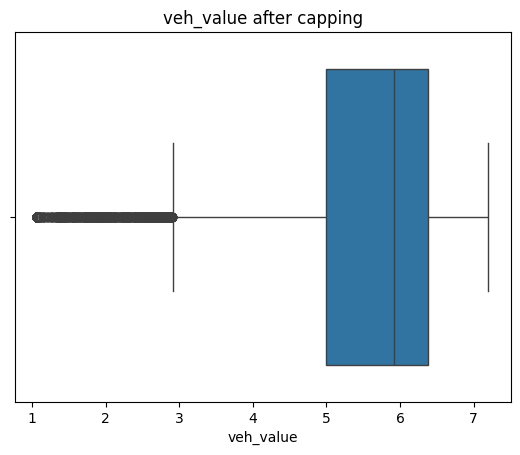

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['veh_value'])
plt.title("veh_value after capping")
plt.show()

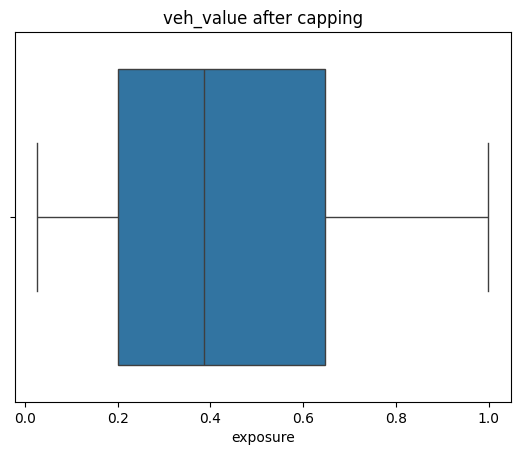

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['exposure'])
plt.title("veh_value after capping")
plt.show()

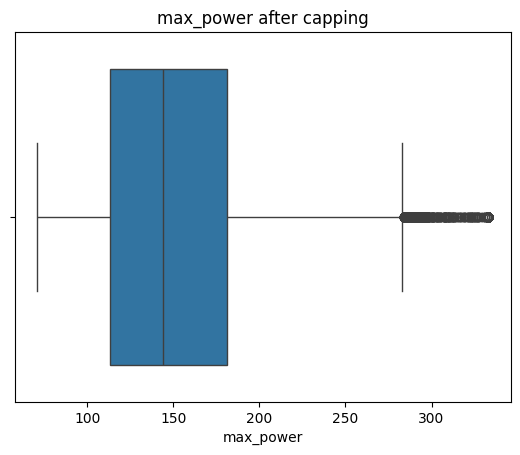

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['max_power'])
plt.title("max_power after capping")
plt.show()

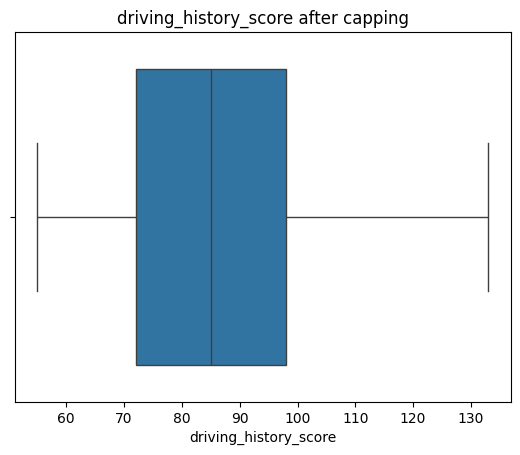

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['driving_history_score'])
plt.title("driving_history_score after capping")
plt.show()

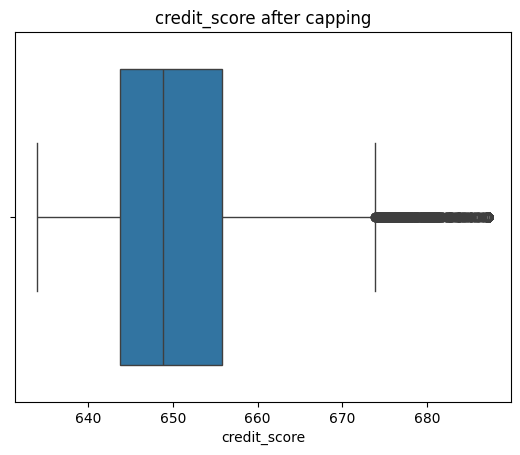

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['credit_score'])
plt.title("credit_score after capping")
plt.show()

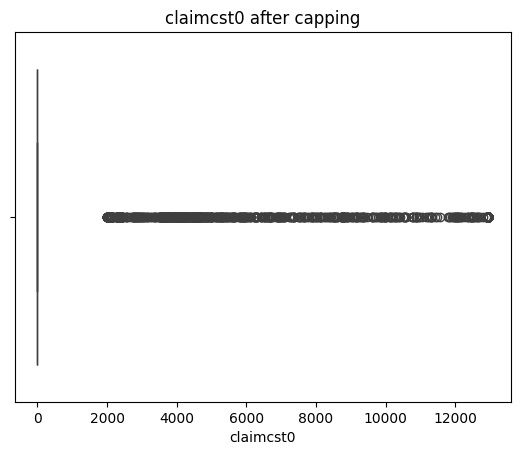

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_data['claimcst0'])
plt.title("claimcst0 after capping")
plt.show()

In [13]:
model_data.head()

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,suv,2,f,b,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,stnwg,4,f,a,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,sedan,2,f,c,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,stnwg,3,m,b,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,sedan,3,m,c,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [14]:
model_data[categorical_cols].head()

,veh_body,engine_type,veh_color,gender,area,marital_status,e_bill,low_education_ind,time_of_week_driven,time_driven,trm_len
0,suv,hybrid,black,f,b,m,0,0.0,weekday,12pm - 6pm,6
1,stnwg,dissel,green,f,a,s,0,0.0,weekend,6am - 12pm,12
2,sedan,petrol,gray,f,c,m,0,0.0,weekday,6am - 12pm,12
3,stnwg,dissel,black,m,b,m,1,0.0,weekday,6pm - 12am,12
4,sedan,petrol,blue,m,c,s,0,0.0,weekday,6am - 12pm,12


In [15]:
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(model_data[col].unique())


--- veh_body ---
['suv' 'stnwg' 'sedan' 'panvn' 'hdtop' 'truck' 'coupe' 'mcara' 'ute'
 'mibus' 'bus' 'convt' 'rdstr']

--- engine_type ---
['hybrid' 'dissel' 'petrol' 'electric']

--- veh_color ---
['black' 'green' 'gray' 'blue' 'silver' 'red' 'white' 'yellow' 'brown']

--- gender ---
['f' 'm']

--- area ---
['b' 'a' 'c' 'd' 'f' 'e']

--- marital_status ---
['m' 's']

--- e_bill ---
['0' '1']

--- low_education_ind ---
['0.0' '1.0']

--- time_of_week_driven ---
['weekday' 'weekend']

--- time_driven ---
['12pm - 6pm' '6am - 12pm' '6pm - 12am' '12am - 6 am']

--- trm_len ---
['6' '12']


## Save Altered Data

In [16]:
model_data.to_csv('../backend/model_data_cleaned.csv', index=False)
inference_data.to_csv('../backend/inference_data_cleaned.csv', index=False)